<a href="https://colab.research.google.com/github/trd44/Caltech-AIML-Bootcamp/blob/main/Detection_of_Lung_Infection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Deep Learning and Computer Vision Project
## Detection of Lung Infection

In [ ]:
# Mounting the drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Import the Necessary Libraries

In [ ]:
import os
import random
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

### Loading the Images

In [ ]:
path = '/content/drive/MyDrive/Datasets/Dataset_Detection_of_Lung_Infection.zip'

with zipfile.ZipFile(path, 'r') as zip:
  zip.extractall()

In [ ]:
train_dir = "/content/data/train/"
train_images = []
train_labels = []
train_image_name = []

test_dir = "/content/data/test/"
test_images = []
test_labels = []
test_image_name = []

In [ ]:
folders = os.listdir(train_dir)

for folder_name in folders:
  
  images_path = os.listdir(train_dir + folder_name +"/")
  
  for i, image_name in enumerate(images_path):
    
    image_path = train_dir + folder_name +"/" + image_name
    image = Image.open(image_path)

    if image.mode != "L":
      image = image.convert('L')

    train_images.append(np.array(image))
    train_labels.append(folder_name)
    train_image_name.append(image_path)


train_images = np.array(train_images)
train_labels = np.array(train_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
folders = os.listdir(test_dir)

for folder_name in folders:
  
  images_path = os.listdir(test_dir + folder_name +"/")
  
  for i, image_name in enumerate(images_path):
    
    image_path = test_dir + folder_name +"/" + image_name
    image = Image.open(image_path)

    if image.mode != "L":
      image = image.convert('L')

    test_images.append(np.array(image))
    test_labels.append(folder_name)
    test_image_name.append(image_path)


test_images = np.array(test_images)
test_labels = np.array(test_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Plot the sample images for all the classes 

(-0.5, 2380.5, 1964.5, -0.5)

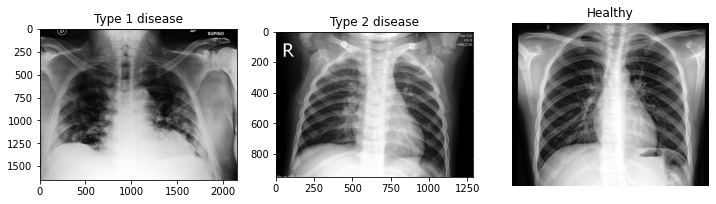

In [ ]:
plt.figure(1, figsize = (12, 12))

plt.subplot(1, 3, 1)
plt.title(train_labels[0])
plt.imshow(train_images[0], cmap="gray")
# print(train_image_name[0])
# print(train_images[0].shape)

plt.subplot(1, 3, 2)
halfway = int(train_labels.shape[0]/2)
plt.title(train_labels[halfway])
plt.imshow(train_images[halfway], cmap="gray")
# print(train_image_name[halfway])
# print(train_images[halfway].shape)

plt.subplot(1, 3, 3)
plt.title(train_labels[-1])
plt.imshow(train_images[-1], cmap="gray")
# print(train_image_name[-1])
# print(train_images[-1].shape)

plt.axis('off')

**Observations:** In the healthy image, the lungs look pretty transparent. In the type 1 disease image, the lungs look very opaque. In the type 2 disease image they seem somewhere in between.

## Plot the distribution of images across the classes

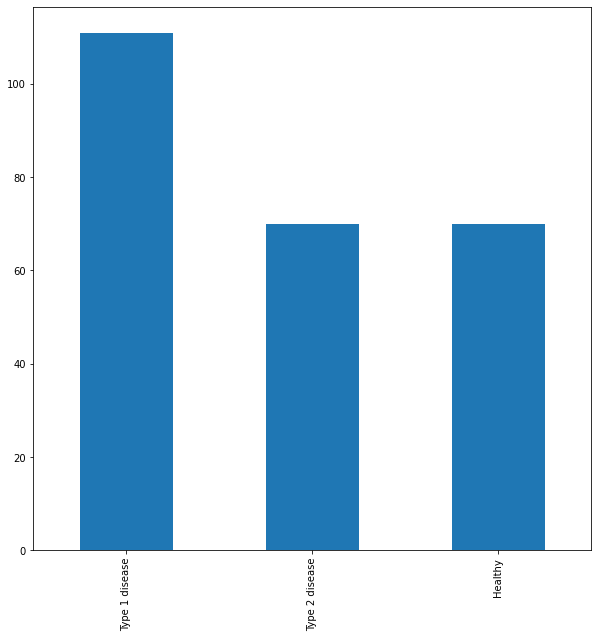

In [ ]:
train_labels_df = pd.DataFrame({'Labels': train_labels})
train_labels_df['Labels'].value_counts().plot(kind='bar',figsize=(10,10))

**Observations:** The data is relatively even. There are about an equal number of Type 2 disease images as healthy images. There are a a good amount more type 1 disease images though. 

## Build a data augmentation for train data to create new data with translation, rescale and flip, and rotation transformations. Rescale the image at 48x48



In [ ]:
import cv2
import copy

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, \
                                    Dropout, RandomTranslation, RandomHeight, \
                                    RandomWidth, RandomFlip, RandomRotation, \
                                    Resizing, Rescaling, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomHeight(factor=0.2),
    RandomWidth(factor=0.2),
    RandomFlip(mode="horizontal_and_vertical"),
    RandomRotation(factor=1.0),
    Resizing(48,48)
    ])

In [ ]:
augmented_train_images = []
augmented_train_labels = []

number_of_augments = 9

In [ ]:
for i, im in enumerate(train_images):
  augmented_train_images.append(np.array(cv2.resize(im, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)))
  augmented_train_labels.append(train_labels[i])

In [ ]:
for i, im in enumerate(train_images):
  
  im = tf.expand_dims(im, 2)

  for j in range(number_of_augments):
    
    augmented_im = np.squeeze(data_augmentation(im))
    augmented_train_images.append(augmented_im)
    augmented_train_labels.append(train_labels[i])


In [ ]:
# print(train_images[0].shape)
# im = tf.expand_dims(train_images[0], 2)
# print(im.shape)
# augmented_im = np.squeeze(data_augmentation(im))
# print(augmented_im.shape)


(1648, 2150)
(1648, 2150, 1)
(48, 48)


In [ ]:
augmented_train_images = np.array(augmented_train_images)

In [ ]:
augmented_train_images = (augmented_train_images/255.0).astype('float32')

## Build a data augmentation for test data to create new data and rescale the image at 48x48

In [ ]:
resized_test_images = []

for i, im in enumerate(test_images):
  resized_test_images.append(np.array(cv2.resize(im, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)))

resized_test_images = np.array(resized_test_images)
resized_test_images = (resized_test_images/255.0).astype('float32')

In [ ]:
key = {'Type 1 disease': 0, 'Type 2 disease': 1, 'Healthy': 2}

In [ ]:
augmented_train_labels = [key[atl] for atl in augmented_train_labels]

In [ ]:
key2 = {'Type 1 disease': 0, 'Type 2 disease': 1, 'healthy': 2}

In [ ]:
test_labels_oh = [key2[tl] for tl in test_labels]

In [ ]:
train_labels_oh = to_categorical(augmented_train_labels)
test_labels_oh = to_categorical(test_labels_oh)

# Build a CNN Model

Add convolutional layers with different filters, max pool layers, dropout layers, and batch normalization layers  

Use Relu as an activation function

Take the loss function as categorical cross-entropy

Take rmsprop as an optimizer

Use early stopping with the patience of two epochs and monitor the validation loss or accuracy

Try with ten numbers epoch

Train the model using a generator and test the accuracy of the test data at every epoch

Plot the training and validation accuracy, and the loss

Observe the precision, recall the F1-score for all classes for both grayscale and color models, and determine if the model’s classes are good

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=32, kernel_size = 5, padding ="same", activation="relu", input_shape=(48,48,1)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=16, kernel_size = 3, padding ="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation="relu"))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(units=3, activation="softmax"))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 16)       

In [ ]:
cnn_model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                    metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

In [ ]:
X, y = shuffle(augmented_train_images, train_labels_oh)

In [ ]:
history_cnn = cnn_model.fit(X, y,
                            batch_size=32,
                            validation_split=0.2,
                            epochs=10,
                            verbose=1,
                            callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 9s 13ms/step - loss: 1.1091 - accuracy: 0.4158 - val_loss: 1.0488 - val_accuracy: 0.4741
Epoch 2/10
63/63 [==============================] - 0s 7ms/step - loss: 1.0375 - accuracy: 0.4701 - val_loss: 1.0307 - val_accuracy: 0.4641
Epoch 3/10
63/63 [==============================] - 0s 6ms/step - loss: 0.9965 - accuracy: 0.5005 - val_loss: 1.0534 - val_accuracy: 0.4542
Epoch 4/10
63/63 [==============================] - 0s 7ms/step - loss: 0.9156 - accuracy: 0.5613 - val_loss: 0.9847 - val_accuracy: 0.4701
Epoch 5/10
63/63 [==============================] - 0s 6ms/step - loss: 0.8476 - accuracy: 0.6056 - val_loss: 1.0179 - val_accuracy: 0.4482
Epoch 6/10
63/63 [==============================] - 0s 7ms/step - loss: 0.7917 - accuracy: 0.6340 - val_loss: 0.8845 - val_accuracy: 0.6275
Epoch 7/10
63/63 [==============================] - 0s 7ms/step - loss: 0.7047 - accuracy: 0.6873 - val_loss: 0.8582 - val_accuracy: 0.6175
Epoch 8/10
63/63 [=

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

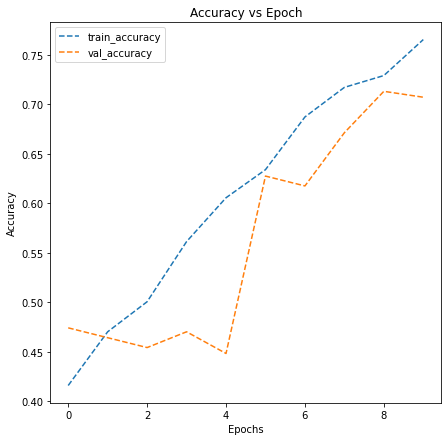

In [ ]:
plot_accuracy(history_cnn)

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

In [ ]:
def evaluate_model(model, images, labels_oh):
  accuracy = model.evaluate(images, labels_oh)
  print('\n', 'Test_Accuracy: ', accuracy[1],'\n')
  
  pred = model.predict(images)
  pred = np.argmax(pred, axis=1)
  y_true = np.argmax(labels_oh, axis=1)
  
  print(classification_report(y_true, pred))

In [ ]:
evaluate_model(cnn_model, resized_test_images, test_labels_oh)

3/3 [==============================] - 0s 28ms/step - loss: 0.2329 - accuracy: 0.8939

 Test_Accuracy:  0.8939393758773804 

3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.78      0.90      0.84        20
           2       0.89      0.80      0.84        20

    accuracy                           0.89        66
   macro avg       0.89      0.89      0.89        66
weighted avg       0.90      0.89      0.90        66



## Transfer learning using mobile net

Prepare data for the pre-trained mobile net model, with color mode as RGB

Create an instance of a mobile net pre-trained model 

Add dense layer, dropout layer, batch normalization layer on the pre-trained model

Create a final output layer with a SoftMax activation function

Change the batch size activation function and optimize as rmsprop and observe if the accuracy increases

Take the loss function as categorical cross-entropy

Use early stopping with the patience of two epoch and call back function for preventing overfitting

Try with ten numbers epoch

Train the model using a generator and test the accuracy of the test data at every epoch

 Plot the training and validation accuracy, and the loss

 Observe the precision, recall the F1-score for all classes for both grayscale

and color models, and determine if the model’s classes are good



In [ ]:
folders = os.listdir(train_dir)

train_images2 = []
train_labels2 = []
train_image_name2 = []

for folder_name in folders:
  
  images_path = os.listdir(train_dir + folder_name +"/")
  
  for i, image_name in enumerate(images_path):
    
    image_path = train_dir + folder_name +"/" + image_name
    image = Image.open(image_path)
    image = image.resize((224,224))

    if image.mode != "RGB":
      image = image.convert('RGB')

    train_images2.append(np.array(image))
    train_labels2.append(folder_name)
    train_image_name2.append(image_path)


train_images2 = np.array(train_images2)
train_labels2 = np.array(train_labels2)

In [ ]:
folders = os.listdir(test_dir)

test_images2 = []
test_labels2 = []
test_image_name2 = []

for folder_name in folders:
  
  images_path = os.listdir(test_dir + folder_name +"/")
  
  for i, image_name in enumerate(images_path):
    
    image_path = test_dir + folder_name +"/" + image_name
    image = Image.open(image_path)
    image = image.resize((224,224))

    if image.mode != "RGB":
      image = image.convert('RGB')

    test_images2.append(np.array(image))
    test_labels2.append(folder_name)
    test_image_name2.append(image_path)


test_images2 = np.array(test_images2)
test_labels2 = np.array(test_labels2)

In [ ]:
data_augmentation2 = tf.keras.Sequential([
    Rescaling(1./255),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomHeight(factor=0.2),
    RandomWidth(factor=0.2),
    RandomFlip(mode="horizontal_and_vertical"),
    RandomRotation(factor=1.0),
    Resizing(224,224)
    ])

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras import Model

In [ ]:
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))

mobilenet.summary()


17225924/17225924 [==============================] - 3s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
transfer_layer = mobilenet.get_layer('conv_pw_13_relu')

mobilenet.trainable = False

x = Flatten()(transfer_layer.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

pred = Dense(3, activation='softmax')(x)

mn_model = Model(inputs=mobilenet.input, outputs=pred)

In [ ]:
mn_model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                    metrics=['accuracy'])

In [ ]:
key = {'Type 1 disease': 0, 'Type 2 disease': 1, 'Healthy': 2}

In [ ]:
train_labels2_cvt = [key[tl] for tl in train_labels2]

In [ ]:
key2 = {'Type 1 disease': 0, 'Type 2 disease': 1, 'healthy': 2}

In [ ]:
test_labels2_cvt = [key2[tl] for tl in test_labels2]

In [ ]:
train_labels2_oh = to_categorical(train_labels2_cvt)
test_labels2_oh = to_categorical(test_labels2_cvt)

In [ ]:
X, y = shuffle(train_images2, train_labels2_oh)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
history2 = mn_model.fit(X, y,
                            batch_size=16,
                            validation_split=0.2,
                            epochs=10,
                            verbose=1,
                            callbacks=callbacks)

Epoch 1/10
13/13 [==============================] - 1s 99ms/step - loss: 0.1148 - accuracy: 0.9650 - val_loss: 0.0595 - val_accuracy: 0.9608
Epoch 2/10
13/13 [==============================] - 1s 90ms/step - loss: 0.0795 - accuracy: 0.9700 - val_loss: 0.0412 - val_accuracy: 0.9608
Epoch 3/10
13/13 [==============================] - 1s 90ms/step - loss: 0.0839 - accuracy: 0.9650 - val_loss: 0.0339 - val_accuracy: 0.9804
Epoch 4/10
13/13 [==============================] - 0s 35ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9804
Epoch 5/10
13/13 [==============================] - 1s 85ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 0s 35ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 0s 34ms/step - loss: 9.4209e-04 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9804


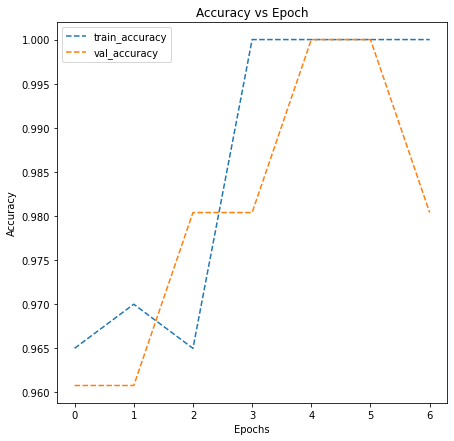

In [ ]:
plot_accuracy(history2)

In [ ]:
evaluate_model(mn_model, test_images2, test_labels2_oh)

3/3 [==============================] - 0s 138ms/step - loss: 0.3419 - accuracy: 0.8939

 Test_Accuracy:  0.8939393758773804 

3/3 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      0.70      0.82        20
           2       0.74      1.00      0.85        20

    accuracy                           0.89        66
   macro avg       0.91      0.89      0.88        66
weighted avg       0.92      0.89      0.89        66



# Transfer Learning using Densenet121

Prepare the dataset for the transfer learning algorithm using Densenet121 with the image size as 224x224x3

Freeze the top layers of the pre-trained model

Add a dense layer at the end of the pre-trained model followed by a dropout layer and try various combinations to get an accuracy

Add the final output layer with a SoftMax activation function

Take loss function as categorical cross-entropy

Take Adam as an optimizer

Use early stopping to prevent overfitting

Try with 15 number of epoch and batch size with seven, also try various values to see the impact on results

Train the model using the generator and test the accuracy of the test data at every epoch 

 Plot the training and validation accuracy, and the loss

Observe the precision, recall the F1-score for all classes for both grayscale

and color models, and determine if the model’s classes are good

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))

densenet121.summary()

In [ ]:
transfer_layer = densenet121.get_layer('relu')

densenet121.trainable=False

x = Flatten()(transfer_layer.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

pred = Dense(3, activation='softmax')(x)

dn_model = Model(inputs=densenet121.input, outputs=pred)

In [ ]:
dn_model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                    metrics=['accuracy'])

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
history3 = dn_model.fit(X, y,
                        batch_size=32,
                        validation_split=0.2,
                        epochs=10,
                        verbose=1,
                        callbacks=callbacks)

Epoch 1/10
7/7 [==============================] - 12s 757ms/step - loss: 0.7973 - accuracy: 0.6800 - val_loss: 5.5135 - val_accuracy: 0.6863
Epoch 2/10
7/7 [==============================] - 1s 119ms/step - loss: 0.2991 - accuracy: 0.8650 - val_loss: 2.3418 - val_accuracy: 0.6667
Epoch 3/10
7/7 [==============================] - 1s 118ms/step - loss: 0.2453 - accuracy: 0.8900 - val_loss: 1.0616 - val_accuracy: 0.6863
Epoch 4/10
7/7 [==============================] - 1s 117ms/step - loss: 0.2701 - accuracy: 0.9150 - val_loss: 0.6987 - val_accuracy: 0.8627
Epoch 5/10
7/7 [==============================] - 1s 119ms/step - loss: 0.1427 - accuracy: 0.9350 - val_loss: 1.1903 - val_accuracy: 0.8627
Epoch 6/10
7/7 [==============================] - 1s 118ms/step - loss: 0.1200 - accuracy: 0.9650 - val_loss: 1.4449 - val_accuracy: 0.8235


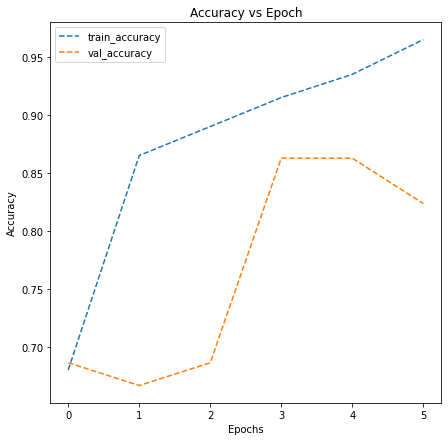

In [ ]:
plot_accuracy(history3)

In [ ]:
evaluate_model(dn_model, test_images2, test_labels2_oh)

3/3 [==============================] - 1s 513ms/step - loss: 2.4511 - accuracy: 0.6970

 Test_Accuracy:  0.6969696879386902 

3/3 [==============================] - 2s 85ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      0.05      0.10        20
           2       0.50      1.00      0.67        20

    accuracy                           0.70        66
   macro avg       0.83      0.67      0.58        66
weighted avg       0.85      0.70      0.62        66



#Conclusion

## CNN Summary

In [ ]:
evaluate_model(cnn_model, resized_test_images, test_labels_oh)

3/3 [==============================] - 0s 5ms/step - loss: 0.2329 - accuracy: 0.8939

 Test_Accuracy:  0.8939393758773804 

3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.78      0.90      0.84        20
           2       0.89      0.80      0.84        20

    accuracy                           0.89        66
   macro avg       0.89      0.89      0.89        66
weighted avg       0.90      0.89      0.90        66



The CNN model had a decent accuracy of 0.89. 
* For Type 1 Disease, the model had a precision of 1.0  meaning there were no false positives. It also had a recall of 0.96 meaning very few false negatives too.
* For Type 2 Disease, the model had a precision of 0.78 meaning there were a bunch of false positives and a recall of 0.90 meaning there were a handful of false negatives
* For Healthy, the model had a precision of 0.89 and a recall of 0.80 which is okay. 

Overall, the model seems really good at identifying Type 1 Disease but seems to confuse Type 2 Disease and Healthy.

## MobileNet Summary

In [ ]:
evaluate_model(mn_model, test_images2, test_labels2_oh)

3/3 [==============================] - 0s 30ms/step - loss: 0.3419 - accuracy: 0.8939

 Test_Accuracy:  0.8939393758773804 

3/3 [==============================] - 0s 40ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      0.70      0.82        20
           2       0.74      1.00      0.85        20

    accuracy                           0.89        66
   macro avg       0.91      0.89      0.88        66
weighted avg       0.92      0.89      0.89        66



The MobileNet model had a decent accuracy of 0.89. 

* For Type 1 Disease, the model had a precision of 1.0 meaning there were no false positives. It also had a recall of 0.96 meaning very few false negatives too.
* For Type 2 Disease, the model had a precision of 1.0 meaning there were no false positives and a recall of 0.70 meaning there were a bunch of false negatives
* For Healthy, the model had a precision of 0.74 meaning there were a bunch of false positives and a recall of 1.0 which means there were no false negatives. 

Overall, the model seems really good at identifying Type 1 Disease but seems to confuse Type 2 Disease and Healthy.

## Densenet121 Summary

In [ ]:
evaluate_model(dn_model, test_images2, test_labels2_oh)

3/3 [==============================] - 0s 77ms/step - loss: 2.4511 - accuracy: 0.6970

 Test_Accuracy:  0.6969696879386902 

3/3 [==============================] - 0s 83ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      0.05      0.10        20
           2       0.50      1.00      0.67        20

    accuracy                           0.70        66
   macro avg       0.83      0.67      0.58        66
weighted avg       0.85      0.70      0.62        66



The Densenet121 model had a poor accuracy of 0.697. 

* For Type 1 Disease, the model had a precision of 1.0 meaning there were no false positives. It also had a recall of 0.96 meaning very few false negatives too.
* For Type 2 Disease, the model had a precision of 1.0 meaning there were no false positives and a recall of 0.05 meaning there were a ton of false negatives
* For Healthy, the model had a precision of 0.50 meaning there were a lot of false positives and a recall of 1.0 which means there were no false negatives. 

Overall, the model seems really good at identifying Type 1 Disease but really seems to confuse Type 2 Disease and Healthy.

# Closing Statement
 The CNN and MobileNet models both had the same test accuracy of 0.89 which is significantly better than the Densenet121 model which only had an accuracy of 0.697. When looking at the precision and recall, I think the CNN model is the better model because it has higher recall for both Type 1 Disease and Type 2 Disease and a high recall for those two classes is most important because you don't want false negatives to occur which would tell the patient they are healthy when they are actually sick.

I think the models struggled to differentiate between Type 2 disease and Healthy because when looking at them with my human eyes they looked very similar. The models seemed to have no problem identifying Type 1 disease, which makes sense to me because the images with Type 1 disease had a lot white in the lungs area which the other two classes did not have.